# Models for Local Volatility - Dupire, CEV, and The Heston Model

Usually you would use market call and put prices and Dupire's equation to estimate local volatility values in a model. This allows us to account for an implied volatility surface.

# 1. CEV Dynamics

The dynamics of the Constanct Elasticity of Variance (CEV) asset prices is as follows:

$$ dS_t = \mu S_t dt + S_t \sigma(S_t,t)dW_t $$

where, 

$ \sigma(S_t, t) = \sigma S_t^{\gamma - 1}$


All other variables are defined as usual in the Black-Scholes model.

#### The Closed-Form Solution to the Value of a Call Option:

$$C(S_0, K, T, \sigma, \gamma) = -S_0 \chi(y;x,x) + K e^{-rT}(1 - \chi(x;z - 2, y))$$

where,

$C(S_0, K, T, \sigma, \gamma)$ is the value of the call on a stock with inistial value $S_0$, strike, K, time to maturity T and $\sigma$ and $\gamma$ as per the CEV volatility terms.


$$\kappa = \frac{2r}{\sigma^2(1-\gamma)e^{2r(1- \gamma)T-1}}$$


$$ x = \kappa S_0^{2(1-\gamma)} e^{2r(1-\gamma)T} $$


$$ y = \kappa K^{2(1-\gamma)} $$


$$ z = 2 + \frac{1}{1-\gamma} $$


and, $\chi(.;d,\lambda)$ is the cdf of a noncentral chi-squared distribution with d degrees of freedom and non-centrality parameter $\lambda$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2

`ncx2.cdf` gets the cdf for noncentral chi-squared distributions

In [2]:
# Variable declaration
S0 = 100
sigma = 0.3
gamma = 0.75
r = 0.1
T = 3

In [12]:
# Call price under CEV Model
z = 2 + 1/(1-gamma)
def call(t,K):
    kappa = 2*r/(sigma**2*(1-gamma)*(np.exp(2*r*(1-gamma)*t)-1))
    x = kappa*S0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S0*(1-ncx2.cdf(y,z,x))-K*np.exp(-r*t)*ncx2.cdf(x,z-2,y)

We need to make this a function of time and stock price, since we need to find the first and second derivatives of the function with respect to these two variables.

**Strike Price** we will use strikes that vary between 80 and 120 (incl.)

In [13]:
# Strikes to test volatility
test_strikes = np.linspace(80,120,41)

# 2. Dupire Equation for Local Volatility

Is used to estimate volatility in simulations. The derivation follows the substitution and manipulation of the Fokker-Planck equation and the Breeden-Litzberger equations to the price of a call option:

$$ C(T,K) = e^{-rT}\int_K^{\infty}(x-K)\phi(x,T)dx$$

### 1. Fokker-Planck Equation:

$$ \frac{\partial{\varphi(x,t)}}{\partial{t}} = - \frac{\partial{\mu(x,t)}\varphi(x,t)}{\partial{x}} + \frac{1}{2} \frac{\partial^2 \sigma(x,t)^2 \varphi(x,t)}{\partial{x^2}} $$

### 2. Breeden-Litzenberger Equations:

$$ \frac{\partial}{\partial{K}} C(T,K) = e^{-rT} \int_K^{\infty} - \varphi(x,T) dx $$

$$ \frac{\partial^2}{\partial{K^2}} C(T,K) = e^{-rT}\varphi(K,T) $$

### Computing Local Volatility

We can derive the Fokker-Planck equation and substitute the result with the Breeden-Litzenberger equations to the Call option price:

$$ \frac{\partial}{\partial{T}} C(T,K) = -rK \frac{\partial}{\partial{K}} C(T,K) + \frac{1}{2} \sigma(K,T)^2\frac{\partial^2}{\partial{K^2}} C(T,K) $$

from which we can derive the local volatility $\sigma(K,T)$

**N.B.** It is common to express $\sigma(K,T)$ as $K\bar{\sigma}(K,T)$ which we express in the following equation:

$$ \bar{\sigma}(K,T)  = \frac{\sqrt 2}{K} \sqrt{\frac{\frac{\partial}{\partial{T}}C(T,K) + rK \frac{\partial}{\partial{K}}C(T,K)}{\frac{\partial^2}{\partial{K^2}}C(T,K)}}$$

We need to estimate:

$\frac{\partial}{\partial{T}}C(T,K)$, $\frac{\partial}{\partial{K}}C(T,K)$, $\frac{\partial^2}{\partial{K^2}}C(T,K)$

### Estimating Derivates

We can do so by following the estimates for derivatives:

$$ \frac{\partial}{\partial{a}}f(a,b,c,...) \approx \frac{f(a+\Delta, b, c, ...) - f(a - \Delta, b, c, ...)}{2\Delta} $$

$$ \frac{\partial^2}{\partial{a^2}}f(a,b,c,...) \approx \frac{f(a+2\Delta, b, c, ...) - 2f(a +\Delta, b, c, ...) + f(a,b,c, ...)}{\Delta^2} $$

Where $\Delta$ is some small number. This approximation comes from the definition of a derivative:

$$ \frac{\partial}{\partial{x}}f(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}$$

In [16]:
# Estimate partial derivatives
delta_t = 0.01
delta_K = 0.01
dC_dT = (call(T+delta_t, test_strikes) - call(T-delta_t, test_strikes))/(2*delta_t)
dC_dK = (call(T, test_strikes + delta_K) - call(T, test_strikes - delta_K))/(2*delta_K)
d2C_dK2 = (call(T, test_strikes+2*delta_K) - 2*call(T, test_strikes + delta_K) + call(T,test_strikes))/(delta_K**2)

#### Estimating Local Volatility under the Dupire Equation:

In [17]:
# estimating local volatility
vol_est = np.sqrt(2)/test_strikes*np.sqrt((dC_dT+r*test_strikes*dC_dK)/d2C_dK2)

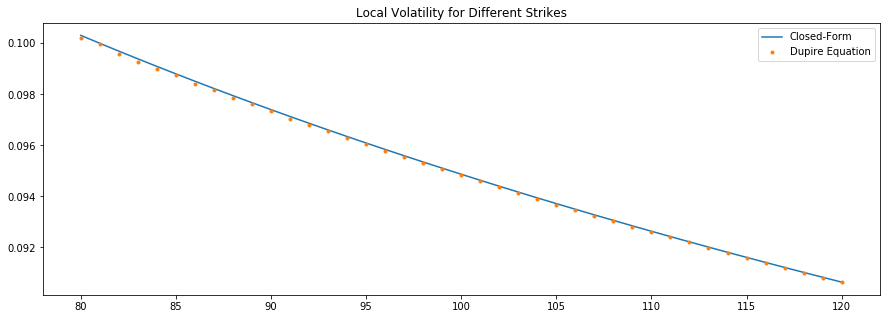

In [38]:
# Plotting the Closed-Form and Dupire Equation
plt.figure(figsize=(15,5))
plt.plot(test_strikes, sigma*test_strikes**(gamma-1), label="Closed-Form")
plt.plot(test_strikes, vol_est, ".", label="Dupire Equation")
plt.title("Local Volatility for Different Strikes")
plt.legend()
plt.show()

### Applications to Put Options

Dupire's equation holds the same for put options:

$$ \bar{\sigma}(K,T)  = \frac{\sqrt 2}{K} \sqrt{\frac{\frac{\partial}{\partial{T}}P(T,K) + rK \frac{\partial}{\partial{K}}P(T,K)}{\frac{\partial^2}{\partial{K^2}}P(T,K)}}$$

# 3. The Heston Model

The Heston model, while it was not the first stochastic volatility model, it was the first to result in a **closed-form characteristic** solution meaning it can be used alongside the Fourier pricing techniques to give analytical priced for vanilla options.

It is the first model to **allow for stochastic volatility** while still capable of being used for **pricing**.

**N.B.** No closed-form pricing solution exists for vanilla options under the Heston model yet.

## The Original Heston Model Dynamics

The original Heston model assumed that risk-free rates are contsant (extensions exists that allow for deterministic and stochastic interest rates as well).

The Heston models assumes assets follow these dynamics:

$$ dS_t = \mu Sdt + \sqrt{\upsilon_t}SdW_t^1 $$

$\upsilon_t$ follows a CIR or square-root process:

$$ d \sqrt{\upsilon_t} = -\beta \sqrt{\upsilon_t}dt + \sigma d W_t^2 $$

Appying Ito's Formuls yields:

$$ d \upsilon_t = \kappa(\theta - \upsilon_t)dt + \sigma \sqrt{\upsilon_t}dW^2_t$$

Where $W_t^2$ is a standard Brownian Motion and has correlation $\rho$ with $W_t^1$.

**N.B.** The **variance process is stochastic** not the volatility process. In this way the volatility will always be positive.

### Characteristic Function of S

This was proposed by Albrecher et al. (2007). We will use this rather than the original as this version is numerically more stable.

Let $s_t = log(S_t)$

$$ \phi_{s_T} = e^{C(\tau,u) + D(\tau;u)\upsilon_t + iu\log(S_t))} $$

Where, 

$$ C(\tau;u) = ri\tau u + \theta \kappa [\tau x_{-} - \frac{1}{a}\log (\frac{1-ge^{d \tau}}{1-g})] $$

$$ D(\tau;u) = (\frac{1-e^{d \tau}}{1-g e^{d \tau}})x_-$$

And

$\tau = T-t$

$g = \frac{x_-}{x_+}$

$x_{\pm} = \frac{b \pm d}{2a}$

$d = \sqrt{b^2 - 4ac}$

$c = - \frac{u^2 + ui}{2}$

$b = \kappa - \rho \sigma i u$

$a = \frac{\sigma^2}{2}$

## Pricing Call Options under the Heston Model

In order to price a call option, we are going to convert the characteristic function directly instead of making a change of measure how it would have been done without Heston Asset Dynamics.

Let $\phi^S_{s_T}(u)$ be the characteristic function of $s_T$, under the measure associated with $S_T$.

$$ \phi^S_{s_T}(u) = \frac{\phi_{s_T}(u-i)}{\phi_{s_T}(-i)} $$

Using this conversion we can now write the:

### Price of a European Call Option:

$$ c = S_0 Q^S[S_T > K] - e^{-rT}KQ[S_T > K] $$

$$ = S_0(\frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}\frac{Im[e^{-it\ln K}\varphi_{M_2}(t)]}{t}dt) -e^{-rT}K(\frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}\frac{Im[e^{-it\ln K}\varphi_{M_1}(t)]}{t}dt) $$

Where, 

$$ \varphi_{M_1}(t) = \phi_{s_T}(t) $$


$$ \varphi_{M_1}(t) = \frac{\phi_{s_T}(u-i)}{\phi_{s_T}(-i)} $$

#### Applying the Discretization of the Integrals

$$ \int_0^{\infty}\frac{Im[e^{-it\ln K}\varphi_{M_i}(t)]}{t}dt \approx \Sigma_{n=1}^N \frac{Im[e^{-it\ln K}\varphi_{M_2}(t)]}{t_n}\Delta t $$

In [40]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

Parameter Specification

In [42]:
# Share specific information
S0 = 100
v0 = 0.06
kappa = 9
theta = 0.06
r = 0.03
sigma = 0.05
rho = -0.4

# Call option specific information
K = 105
T = 0.5
k_log = np.log(K)

# Approximation information
t_max = 30 ## upper bound for the discretized interval
N = 100 ## upper bound for the sum

In [49]:
# Characteristic function code

a = sigma**2/2

def b(u):
    return kappa - rho*sigma*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u) - d(u))/(2*a)

def xplus(u):
    return (b(u) + d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val_1 = T*xminus(u) -np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val_1

def D(u):
    val_1 = 1-np.exp(-T*d(u))
    val_2 = 1-g(u)*np.exp(-T*d(u))
    return (val_1/val_2)*xminus(u)

# M1
def log_char(u):
    return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S0))

# M2
def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

Vectorize the code

In [50]:
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

Calculate Estimates for the Integrals

In [51]:
first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

#### Calculate the Fourier Estimate of the Call Option

In [53]:
fourier_call_value = S0*(1/2 + first_integral/np.pi) - np.exp(-r*T)*K*(1/2 + second_integral/np.pi)

In [54]:
fourier_call_value

5.42395511446901

The computations are cheaper using this method than models that require expensive Monte Carlo simulations

#### Plot how quickly the additional terms in the integral approximation go to zero

It is a great way to illustrate the power of the characteristic pricing method

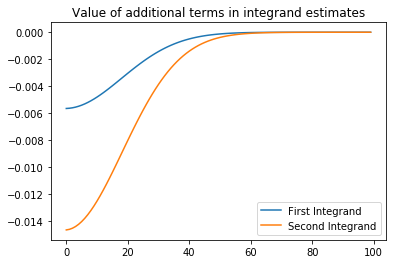

In [56]:
plt.title("Value of additional terms in integrand estimates")

plt.plot((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t, label="First Integrand")
plt.plot((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t, label="Second Integrand")
# plt.xlabel("t")
# plt.ylabel("Integrand Value")
plt.legend()
plt.show()